In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
data_bin = pd.read_csv('data/data_processed_cat.csv')

In [33]:
data_bin.head()

,age,label,sex,weight,height,BMI,centyl,mean_for_age,SD_populacji,Z_score_BMI,...,EPA,C22:2n-6,C22:4n-6,C22:5n-6,C24:0,C24:1n-9,C22:5n-3,DHA,AA/DGLA,DGLA/LA
0,16.282192,0,0,94.5,1.65,34.710744,97.00000,20.790000,2.500000,5.568298,...,0.567,0.112,0.196,0.158,0.151,0.436,1.547,1.68,0.881664,0.226844
1,13.432877,0,1,67.0,1.60,26.171875,96.00000,19.100000,2.750000,2.571591,...,0.390,0.250,0.280,0.150,0.130,0.670,1.310,2.52,3.193548,0.161374
2,11.879452,0,1,70.0,1.56,28.763971,74.19685,19.299194,2.701382,0.855838,...,0.950,0.330,0.510,0.130,0.210,0.600,1.710,1.85,2.092457,0.222764
3,10.904110,0,0,62.0,1.45,29.488704,74.19685,19.299194,2.701382,0.855838,...,0.270,0.240,0.470,0.410,0.250,0.430,1.610,2.23,1.568849,0.243139
4,18.265753,0,1,79.5,1.72,26.872634,97.00000,21.640000,2.690000,1.945217,...,0.910,0.190,0.300,0.250,0.470,1.050,1.410,2.98,1.467967,0.170871


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, f1_score
from sklearn.metrics import RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB


In [17]:
def perform_evaluation(model, test_data, y_true):
    preds = model.predict(test_data)
    acc = accuracy_score(y_true, preds)
    f1 = f1_score(y_true, preds)
    cm = confusion_matrix(y_true,preds)
    mislabeled = cm[0][1] + cm[1][0]
    print(acc, f1)
    print(classification_report(y_true,preds))

def perform_training(data, test_size, binary = True, random = False):
    if random:
        rd_state = np.random.randint(1,100)
    else:
        rd_state = 71
    X = data.drop(columns=['label'])
    y = data['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rd_state)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)


In [37]:
X = data_bin.drop(columns=['label'])
y = data_bin['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=71)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
rf_model = RandomForestClassifier(n_estimators=4,max_features='sqrt',random_state=71)
rf_model.fit(X_train,y_train)
perform_evaluation(rf_model, X_test, y_test)


0.8909090909090909 0.918918918918919
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        18
           1       0.92      0.92      0.92        37

    accuracy                           0.89        55
   macro avg       0.88      0.88      0.88        55
weighted avg       0.89      0.89      0.89        55



(1.0, 30.0)

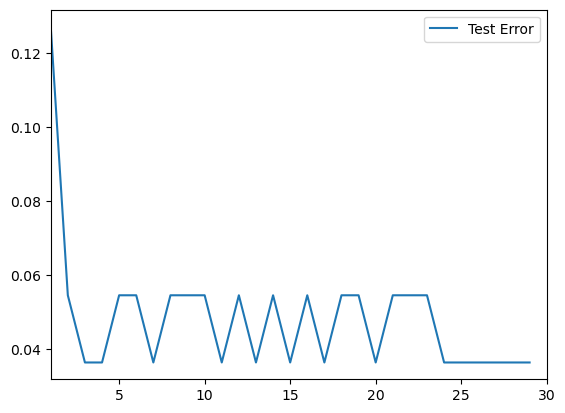

In [20]:
test_error = []

for n in range(1,30):
    model = DecisionTreeClassifier(max_depth=n)
    model.fit(X_train,y_train)
    test_preds = model.predict(X_test)
    test_error.append(1-accuracy_score(test_preds,y_test))
plt.plot(range(1,30),test_error,label='Test Error')
plt.legend()
plt.xlim((1,30))

In [38]:
rf_model = RandomForestClassifier(n_estimators=100,max_features='sqrt',random_state=71)
rf_model.fit(X_train,y_train)
preds = rf_model.predict(X_test)
print(confusion_matrix(y_test,preds))
print(classification_report(y_test,preds))
pd.DataFrame(index=X.columns,data=rf_model.feature_importances_,columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)

[[16  1  1]
 [ 0 19  3]
 [ 0  0 15]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        18
           1       0.95      0.86      0.90        22
           2       0.79      1.00      0.88        15

    accuracy                           0.91        55
   macro avg       0.91      0.92      0.91        55
weighted avg       0.92      0.91      0.91        55



,Feature Importance
BMI,0.083770
C12:0,0.079014
C11:0,0.050673
C10:0,0.050107
GPx,0.048863
...,...
C22:4n-6,0.000432
niejednorodnie podwyższona echogeniczność,0.000091
sex,0.000068
zmiany ogniskowe,0.000000


In [39]:
dt_model = DecisionTreeClassifier(max_depth=4)
dt_model.fit(X_train,y_train)
preds = dt_model.predict(X_test)
print(confusion_matrix(y_test,preds))
print(classification_report(y_test,preds))

pd.DataFrame(index=X.columns,data=dt_model.feature_importances_,columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)

[[18  0  0]
 [ 2 19  1]
 [ 0  0 15]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        18
           1       1.00      0.86      0.93        22
           2       0.94      1.00      0.97        15

    accuracy                           0.95        55
   macro avg       0.95      0.95      0.95        55
weighted avg       0.95      0.95      0.94        55



,Feature Importance
BMI,0.347036
C11:0,0.332085
C12:0,0.193600
TBARS,0.039705
proinsulina,0.026641
...,...
LDL,0.000000
Lp(a),0.000000
ApoB,0.000000
ApoA1,0.000000


In [40]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train,y_train)
preds = knn_model.predict(X_test)
print(confusion_matrix(y_test,preds))
print(classification_report(y_test,preds))

[[14  1  3]
 [ 0 21  1]
 [ 0  2 13]]
              precision    recall  f1-score   support

           0       1.00      0.78      0.88        18
           1       0.88      0.95      0.91        22
           2       0.76      0.87      0.81        15

    accuracy                           0.87        55
   macro avg       0.88      0.87      0.87        55
weighted avg       0.89      0.87      0.87        55



In [41]:
log_model = LogisticRegression(solver='saga',multi_class="ovr",max_iter=5000)
log_model.fit(X_train,y_train)
preds = log_model.predict(X_test)
print(confusion_matrix(y_test,preds))
print(classification_report(y_test,preds))

[[16  0  2]
 [ 0 21  1]
 [ 0  1 14]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        18
           1       0.95      0.95      0.95        22
           2       0.82      0.93      0.87        15

    accuracy                           0.93        55
   macro avg       0.93      0.93      0.92        55
weighted avg       0.93      0.93      0.93        55



In [42]:
svc_model = SVC(kernel='linear', C=1000)
svc_model.fit(X_train,y_train)
preds = svc_model.predict(X_test)
print(confusion_matrix(y_test,preds))
print(classification_report(y_test,preds))

[[17  0  1]
 [ 2 20  0]
 [ 0  2 13]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.92        18
           1       0.91      0.91      0.91        22
           2       0.93      0.87      0.90        15

    accuracy                           0.91        55
   macro avg       0.91      0.91      0.91        55
weighted avg       0.91      0.91      0.91        55



In [45]:
ada_model = AdaBoostClassifier(n_estimators=30)
ada_model.fit(X_train,y_train)
preds = ada_model.predict(X_test)
print(confusion_matrix(y_test,preds))
print(classification_report(y_test,preds))
pd.DataFrame(index=X.columns,data=ada_model.feature_importances_,columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)

[[ 9  9  0]
 [ 1 16  5]
 [ 0  0 15]]
              precision    recall  f1-score   support

           0       0.90      0.50      0.64        18
           1       0.64      0.73      0.68        22
           2       0.75      1.00      0.86        15

    accuracy                           0.73        55
   macro avg       0.76      0.74      0.73        55
weighted avg       0.76      0.73      0.72        55



,Feature Importance
C12:0,0.500000
C18:3n6/C18:2n6,0.333333
Z_score_BMI,0.033333
C11:0,0.033333
height,0.033333
...,...
Lp(a),0.000000
ApoE,0.000000
ApoB,0.000000
ApoA1,0.000000


In [46]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train,y_train)
preds = gb_model.predict(X_test)
print(confusion_matrix(y_test,preds))
print(classification_report(y_test,preds))
pd.DataFrame(index=X.columns,data=gb_model.feature_importances_,columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)

[[18  0  0]
 [ 0 21  1]
 [ 0  0 15]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      0.95      0.98        22
           2       0.94      1.00      0.97        15

    accuracy                           0.98        55
   macro avg       0.98      0.98      0.98        55
weighted avg       0.98      0.98      0.98        55



,Feature Importance
BMI,0.318270
C12:0,0.215150
C11:0,0.202743
EPA,0.103456
GPx,0.028492
...,...
niejednorodnie podwyższona echogeniczność,0.000000
Free BP-3,0.000000
wątroba powiększona,0.000000
sex,0.000000


In [47]:
RocCurveDisplay.from_predictions(y_test, preds)

ValueError: The target y is not binary. Got multiclass type of target.

In [21]:
pd.DataFrame(index=X.columns,data=rf_model.feature_importances_,columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)

,Feature Importance
visceral.1,0.159223
GGTP,0.158886
beta-karoten,0.155174
proinsulina,0.151019
mean_for_age,0.084871
...,...
ApoA1,0.000000
LCAT,0.000000
TG,0.000000
HOMA IR,0.000000


p:\Conda\envs\mgr\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
p:\Conda\envs\mgr\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


<Axes: >

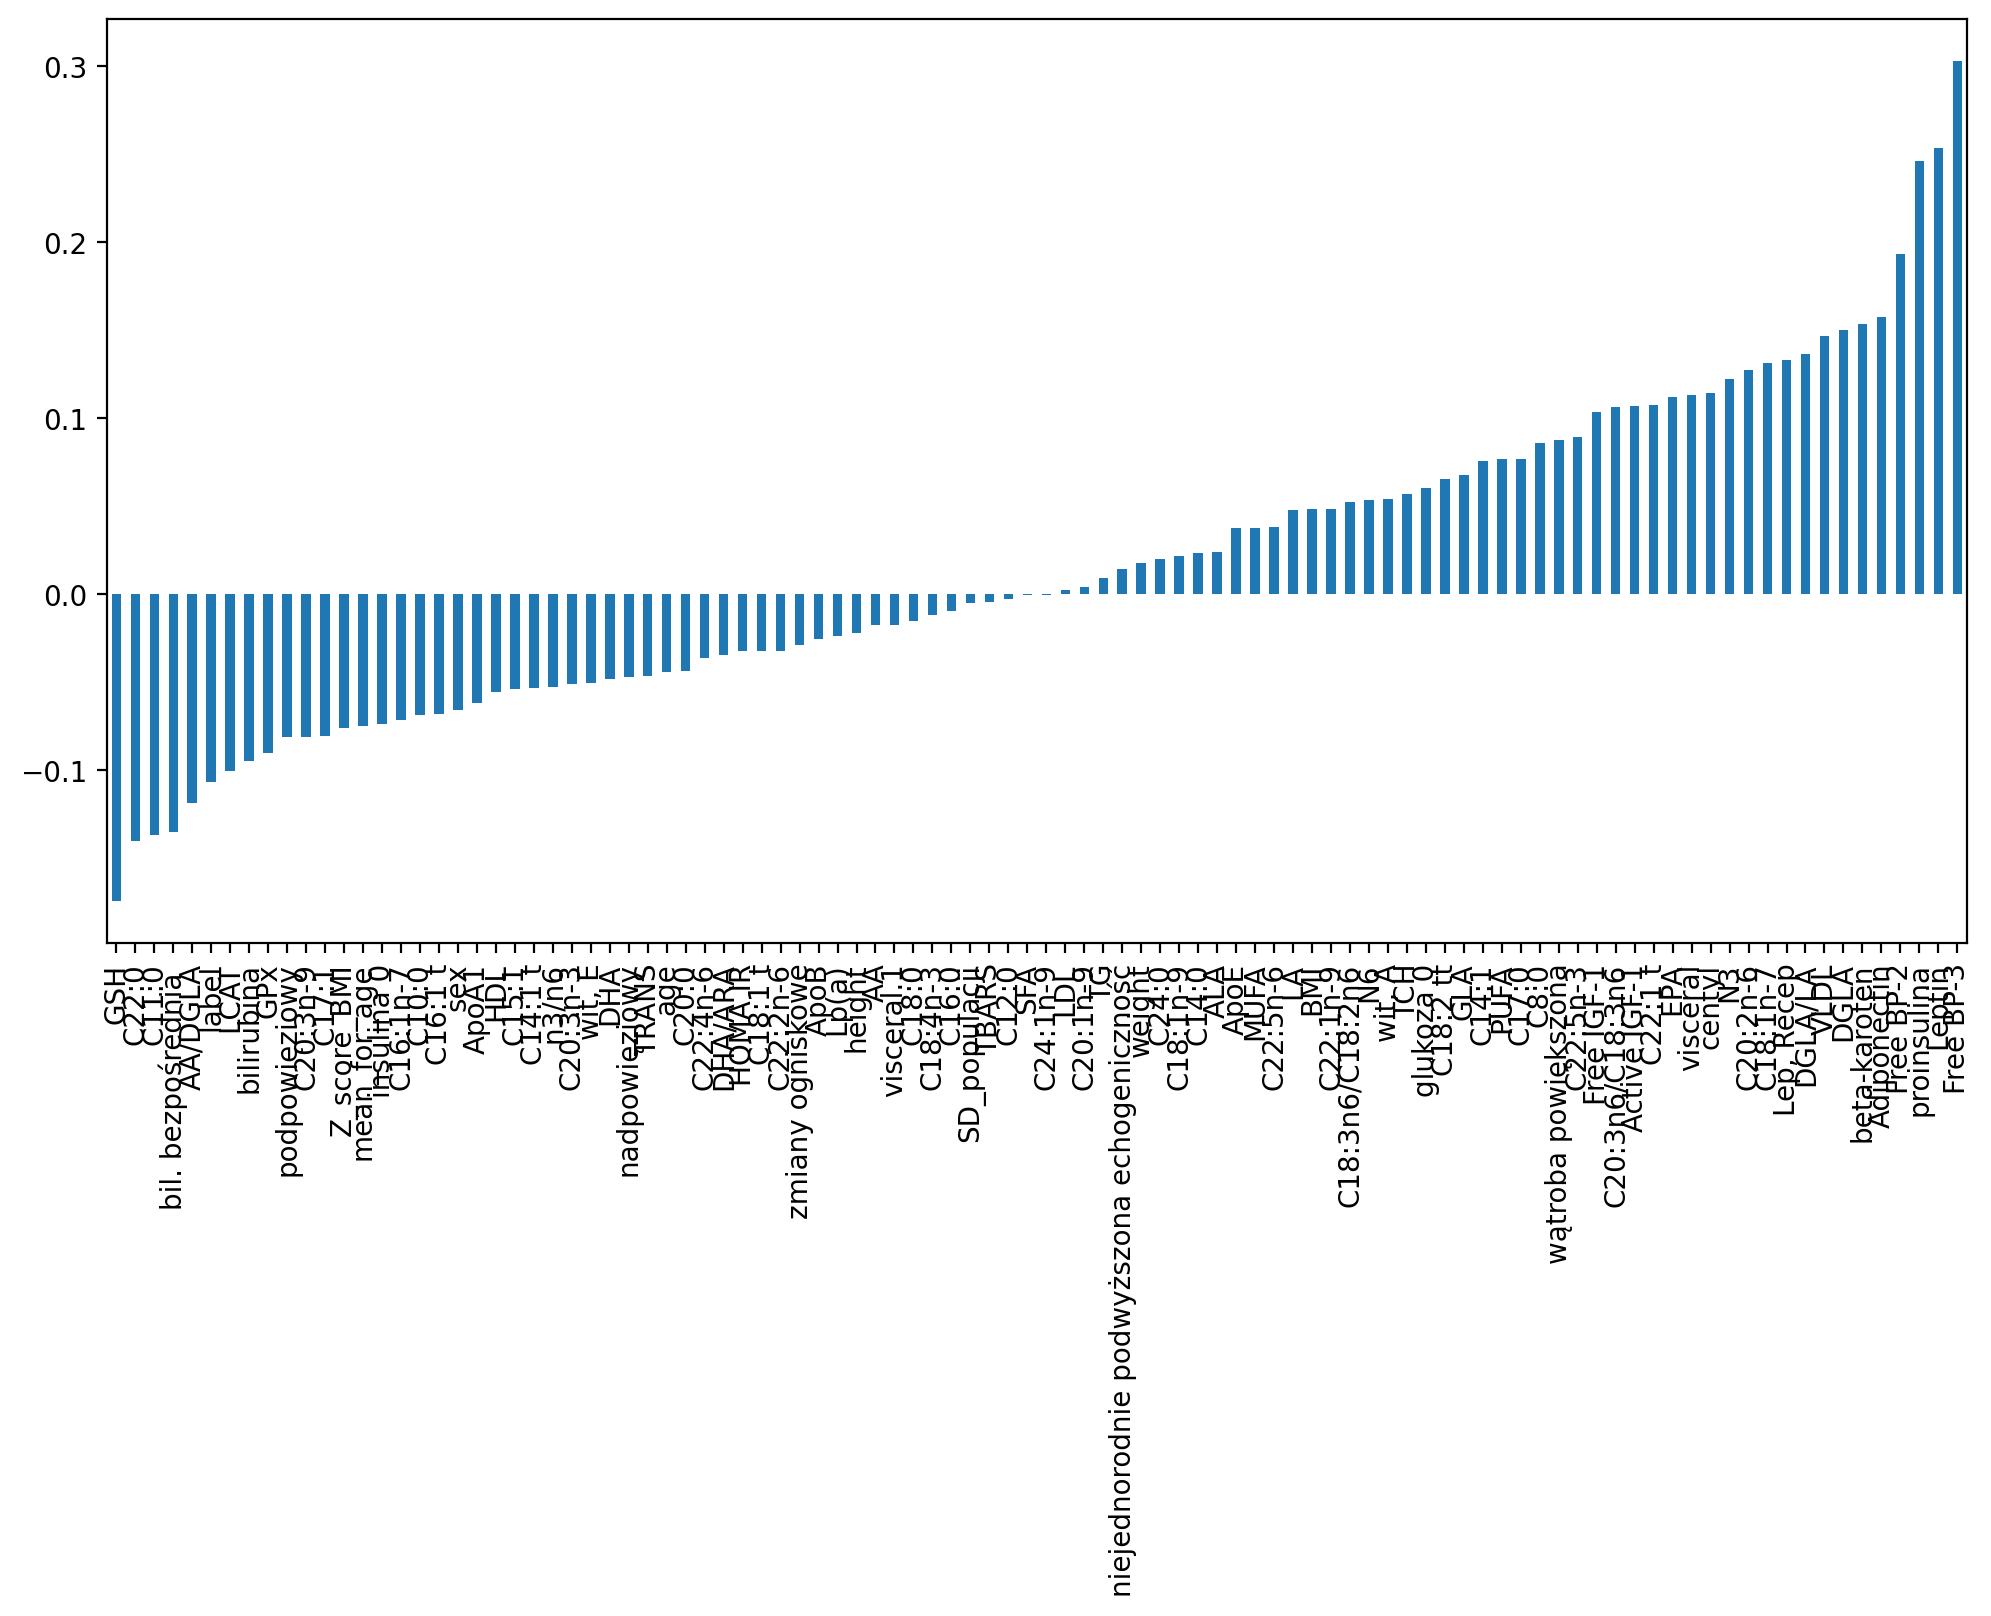

In [29]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=3)

cluster_labels = model.fit_predict(X)

cluster_data = data_bin.copy()
cluster_data['cluster'] = cluster_labels
cluster_data.corr()['cluster']

plt.figure(figsize=(12,6),dpi=200)
cluster_data.corr()['cluster'].iloc[:-1].sort_values().plot(kind='bar')

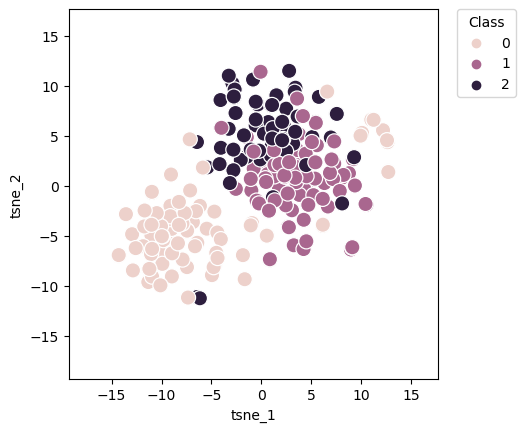

In [48]:

from sklearn.manifold import TSNE
y_true = y_test.copy()
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(X_train)
tsne_result.shape
y_true = np.reshape(y_true, (y_true.shape[0],))

y_tsne = np.reshape(y_train, (y_train.shape[0],))
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y_tsne})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, title = 'Class')
plt.show()